### Import libraries

In [1]:
import matplotlib.pyplot as plt
from scipy import integrate

import torch
import torch.nn as nn
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

### Recap on (Damped) Harmonic Oscillators

In classical mechanics, a harmonic oscillator is a system in which a mass experiences a restoring force proportional to its displacement from equilibrium. If we let $x$ be the displacement of the mass $m$ from the equilibrium $x=0$, by the Hooke's law, the restoring force $F_r$ has the following form:

$$F_r=-kx.$$

Also, from the Newton's second law of motion $F=m\frac{\partial^2 x}{\partial t^2}$, where the second order derivative with respect to time $t$, we have the following relationship:

$$m\frac{\partial^2 x}{\partial t^2} + kx = 0.$$

In an ideal harmonic oscillator as in the above, the mass oscillates indefinitely with constant amplitude and frequency. However, real-world oscillators are often damped and experience a resistive or damping force that opposes its motion. This means that they gradually lose energy due to frictional or resistive forces, causing the oscillations to decrease in amplitude over time. Such a damping force, say $F_d$ can be modeled as being proportional to the velocity $\frac{\partial x}{\partial t}$ of the mass, or $F_d=-c\frac{\partial x}{\partial t}$, where $c$ is called the damping coefficient.

The Newton's second law for damped harmonic oscillators then becomes:

$$F_\text{total} = F_r + F_d = -kx-c\frac{\partial x}{\partial t} = m\frac{\partial^2 x}{\partial t^2},$$

which can be rewritten into a more intuitive form:

$$\frac{\partial^2 x}{\partial t^2} + 2\zeta\omega_0\frac{\partial x}{\partial t} + \omega_0^2 x = 0,$$

where $\omega_0:=\sqrt{\frac{k}{m}}$ is the angular frequency of the oscillator and $\zeta:=\frac{c}{2\sqrt{mk}}$ is called the damping ratio.

The value of the damping ratio can vary and critically determine the behavior of the system, affecting whether the system returns to equilibrium without oscillating (overdamping; $\zeta>1$), oscillates with a gradually reducing amplitude (underdamping; $\zeta<1$), or quickly comes to rest without oscillating (critical damping; $\zeta=1$).

Oftentimes, it is more convenient to use the state space representation of a damped harmonic oscillator, expressesing the system's dynamics using a set of first-order differential equations that describe its state at any given time. The state vector, typically represented by $\mathbf{x}(t)$, includes position $x$ and velocity $\dot{x}:=\frac{\partial x}{\partial t}$, which fully describe the system's current condition:

$$\mathbf{x}(t) = \begin{bmatrix} x(t) \\ \dot{x}(t) \end{bmatrix}.$$

Then the original second-order differential equation of the harmonic oscillator above then becomes a system of first-order differential equations:

$$\frac{d}{dt}\mathbf{x}(t)=\begin{bmatrix} 0 & 1 \\ -2\zeta\omega_0 & -\omega_0^2\end{bmatrix}\mathbf{x}(t)$$

where the matrix 
$$A:=\begin{bmatrix} 0 & 1 \\ -2\zeta\omega_0 & -\omega_0^2\end{bmatrix}$$
is called the system matrix.

Finally, in the underdamped or critically damped cases where $\zeta \leq 1$, the analytical solution for the state space representation of a damped harmonic oscillator can be expressed as damped sinusoidal oscillations:

$$\mathbf{x}(t) = ae^{-\zeta\omega_0 t}\sin(\sqrt{1-\zeta^2}\omega_0t + \varphi),$$

where the amplitude $a$ and phase $\varphi$ are coefficients determined from the initial conditions.

### Implementation of the Ground Truth (Analytic Solution)

Now that we have briefly looked into the theory behind harmonic oscillators, let us get our hands dirty and implement this in a python code:

In [2]:
# TODO: Write a function to determine the amplitude a and phase phi from a given initial condition
def determineCoefficients(X0, zeta, omega0):
    ''' Determine amplitude a and phase phi.

    Inputs:
        X0: torch.tensor of size (2,) containing initial position and velocity.
        zeta: damping ratio.
        omega0: angular frequency.

    Returns:
        Amplitude a and phase phi that match the initial condition X0.
    '''
    assert zeta <= 1, "zeta must be under-/critically-damped (zeta <= 1)"

    # TODO: Complete the code
    if torch.abs((X0[1] + zeta*omega0*X0[0])) < 1e-7:
        phi = 0.5*torch.pi
    else:
        num = torch.sqrt(torch.tensor(1-zeta**2, dtype=dtype))*omega0*X0[0]
        den = X0[1] + zeta*omega0*X0[0]
        phi = torch.arctan(num/den)
    a = X0[0]/torch.sin(phi)

    return a, phi


# Initial condition
X0 = torch.tensor([1, 0], dtype=dtype)   # initial condition
omega0 = 2*torch.pi                      # angular frequency
zeta = 0.15                               # damping ratio (<= 1)

# Determine coefficients
a, phi = determineCoefficients(X0, zeta, omega0)

# Create ground truth data
Nt = 1000    # number of time steps
Tmax = 3
t = torch.linspace(0, Tmax, Nt, dtype=dtype)
# TODO: Write the analytic solution (ground truth) for the state x(t)
ezot = torch.exp(-zeta*omega0*t)
sqrt_omega = torch.sqrt(torch.tensor(1-zeta**2, dtype=dtype))*omega0
position = a*ezot*torch.sin(sqrt_omega*t + phi)
# velocity = -a*zeta*omega0*ezot*torch.sin(sqrt_omega*t + phi) + a*ezot*sqrt_omega*torch.cos(sqrt_omega*t + phi)
# GT = torch.stack([position,velocity], axis=0).T
GT = torch.unsqueeze(position,-1)
print(GT)

tensor([[ 1.0000e+00],
        [ 9.9982e-01],
        [ 9.9929e-01],
        [ 9.9841e-01],
        [ 9.9717e-01],
        [ 9.9559e-01],
        [ 9.9367e-01],
        [ 9.9140e-01],
        [ 9.8880e-01],
        [ 9.8586e-01],
        [ 9.8258e-01],
        [ 9.7898e-01],
        [ 9.7504e-01],
        [ 9.7079e-01],
        [ 9.6621e-01],
        [ 9.6132e-01],
        [ 9.5611e-01],
        [ 9.5059e-01],
        [ 9.4477e-01],
        [ 9.3864e-01],
        [ 9.3221e-01],
        [ 9.2549e-01],
        [ 9.1848e-01],
        [ 9.1118e-01],
        [ 9.0361e-01],
        [ 8.9575e-01],
        [ 8.8762e-01],
        [ 8.7922e-01],
        [ 8.7055e-01],
        [ 8.6163e-01],
        [ 8.5245e-01],
        [ 8.4301e-01],
        [ 8.3334e-01],
        [ 8.2342e-01],
        [ 8.1326e-01],
        [ 8.0288e-01],
        [ 7.9226e-01],
        [ 7.8143e-01],
        [ 7.7038e-01],
        [ 7.5912e-01],
        [ 7.4765e-01],
        [ 7.3598e-01],
        [ 7.2412e-01],
        [ 7

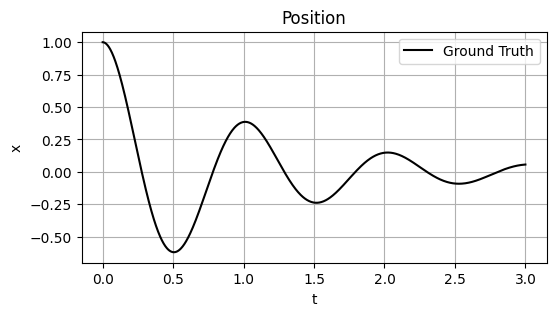

In [3]:
plt.figure(figsize=(6,3))
# plt.subplot(1,2,1)
plt.plot(t, GT[:,0], color='black', label = "Ground Truth")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.title('Position')
plt.legend()
# plt.subplot(1,2,2)
# plt.plot(t, GT[:,1], color='black', label = "Ground Truth")
# plt.grid()
# plt.xlabel("t")
# plt.ylabel("dx/dt")
# plt.title('Velocity')
# plt.legend()

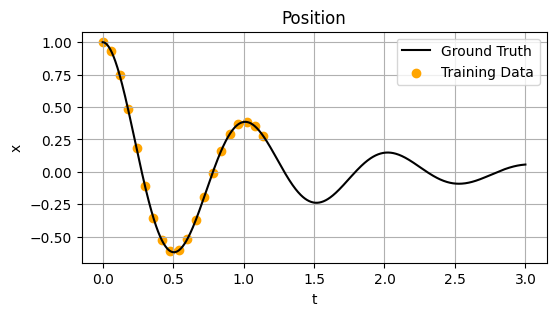

In [4]:
Tmax_sample = 1.2       # maximum time for training sample
sample_stride = 20       # stride between samples

Nt_sample = int(Nt*Tmax_sample/Tmax)

t_sample = torch.unsqueeze(t[0:Nt_sample:sample_stride], -1)
GT_sample = GT[0:Nt_sample:sample_stride,:]

training_data = torch.hstack((t_sample, GT_sample))  # t, x

plt.figure(figsize=(6,3))
# plt.subplot(1,2,1)
plt.plot(t, GT[:,0], color='black', label = "Ground Truth")
plt.scatter(training_data[:,0], training_data[:,1], color='orange', label='Training Data')
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.title('Position')
plt.legend()
# plt.subplot(1,2,2)
# plt.plot(t, GT[:,1], color='black', label = "Ground Truth")
# plt.scatter(training_data[:,0], training_data[:,2], color='orange', label='Training Data')
# plt.grid()
# plt.xlabel("t")
# plt.ylabel("dx/dt")
# plt.title('Velocity')
# plt.legend()

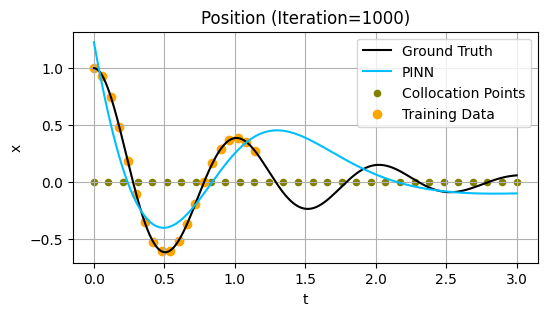

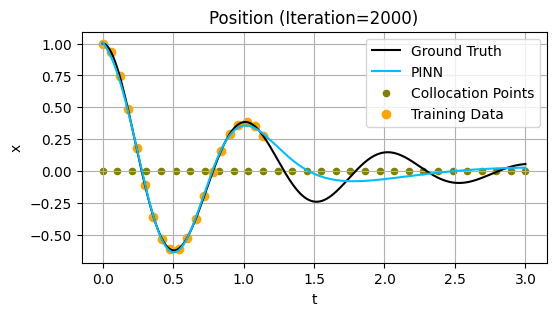

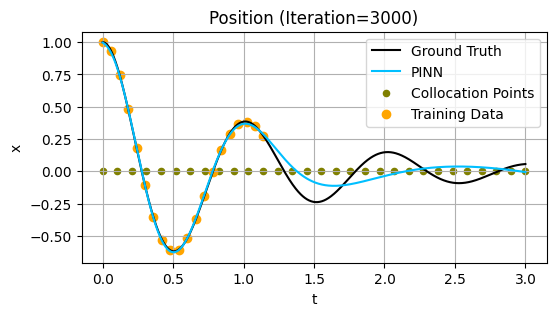

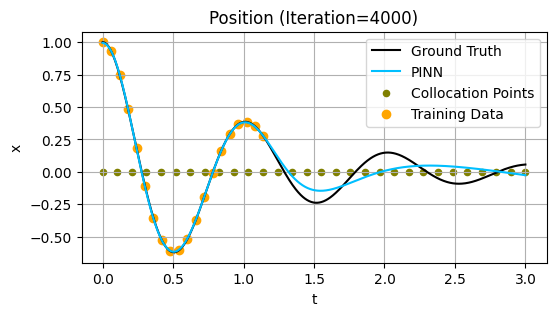

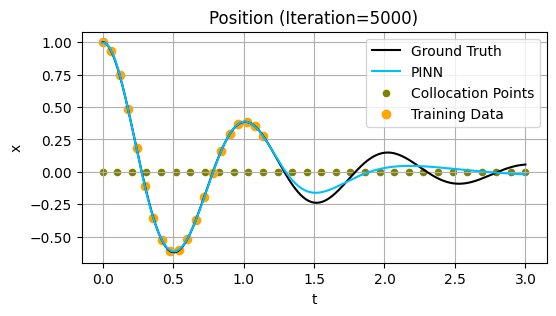

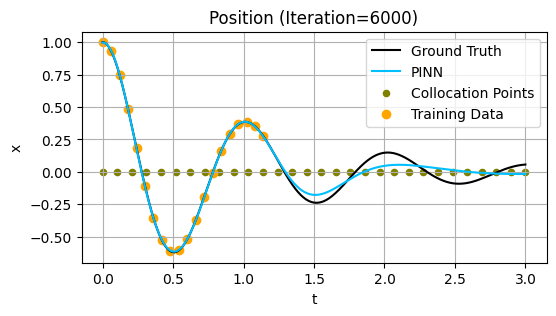

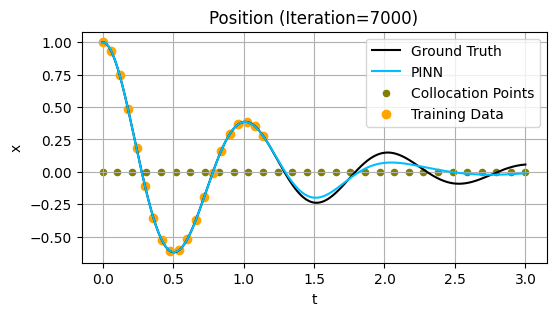

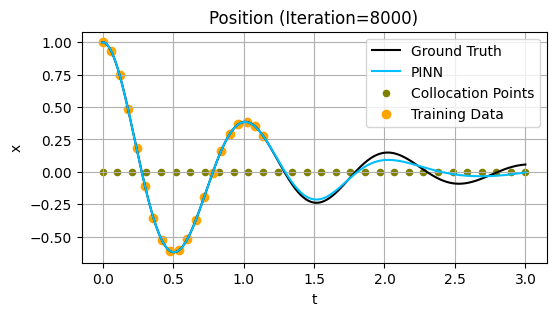

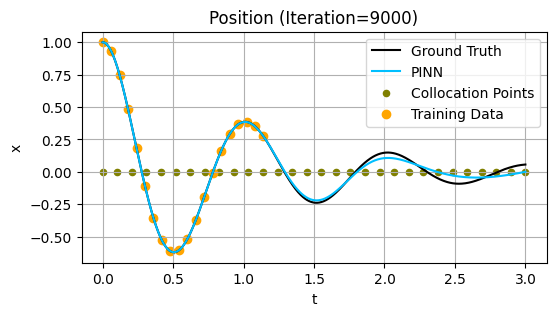

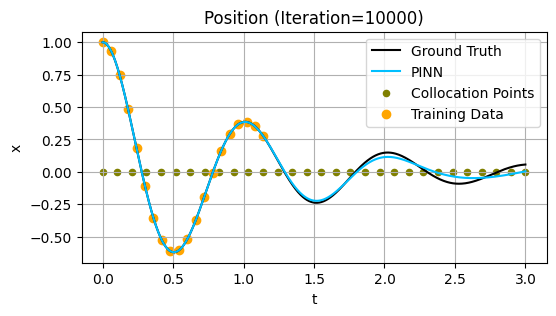

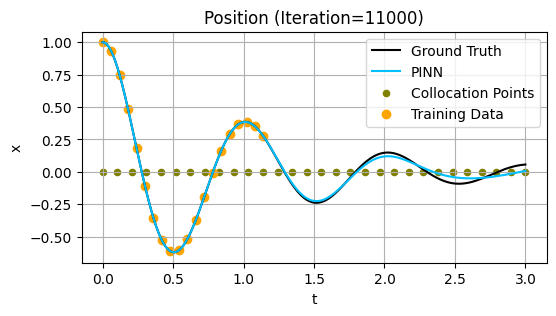

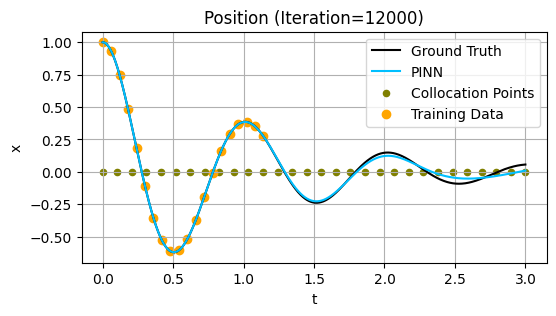

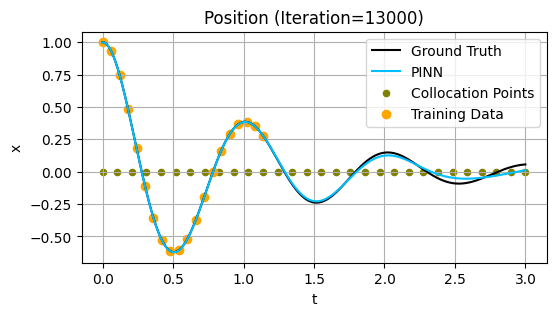

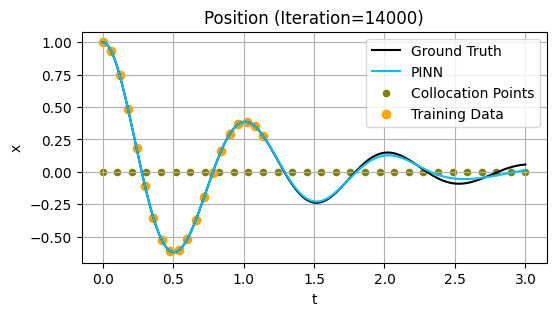

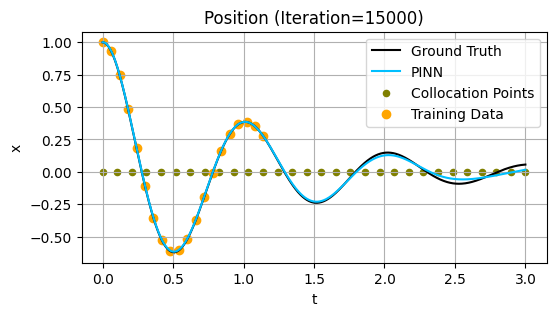

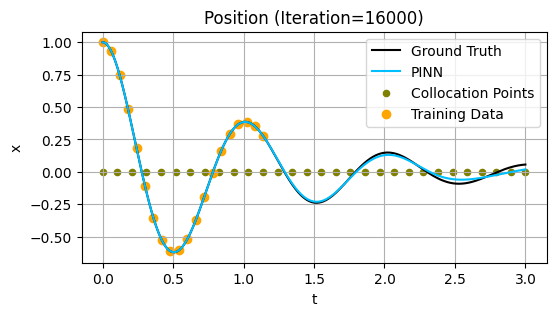

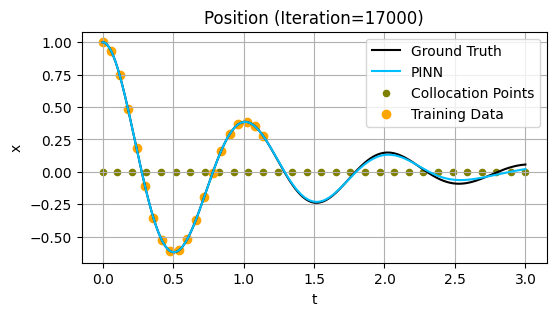

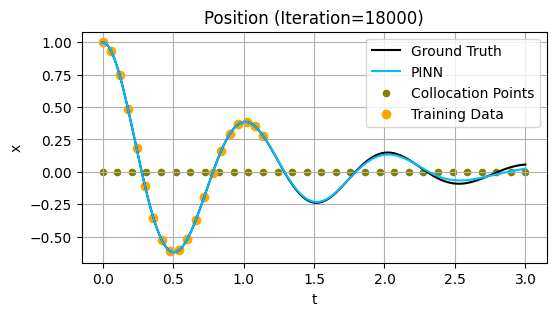

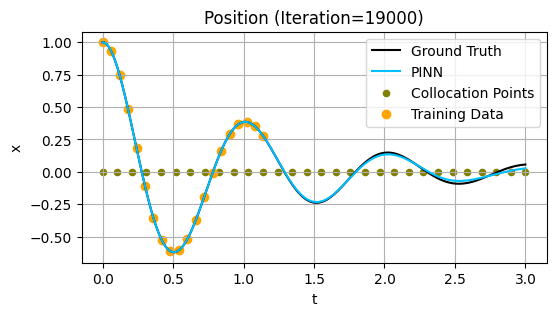

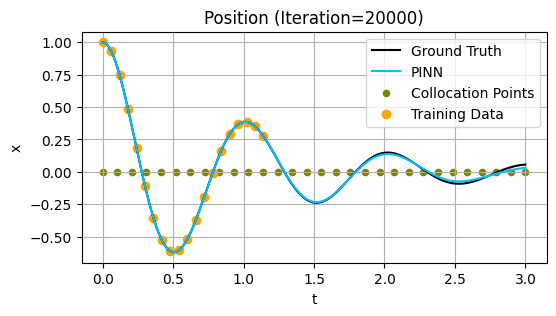

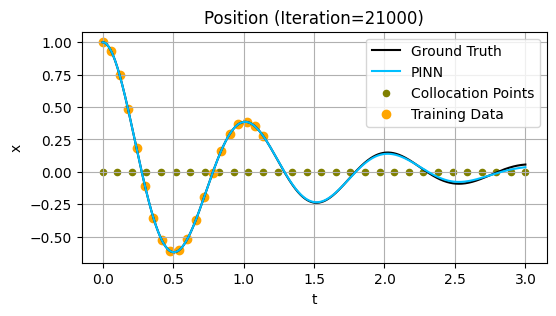

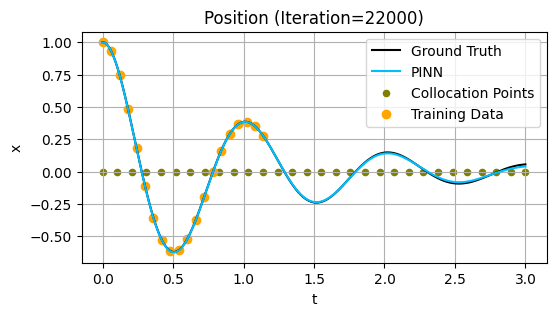

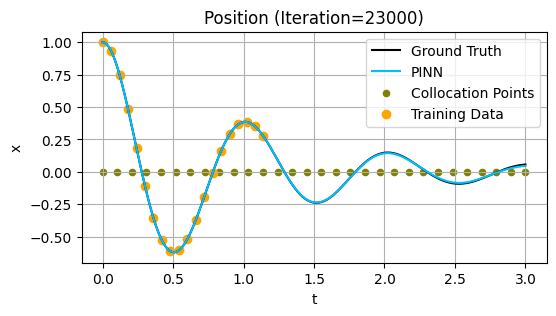

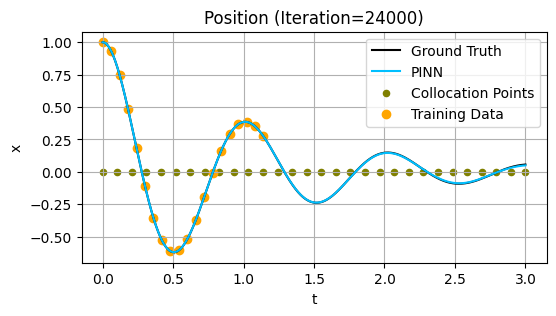

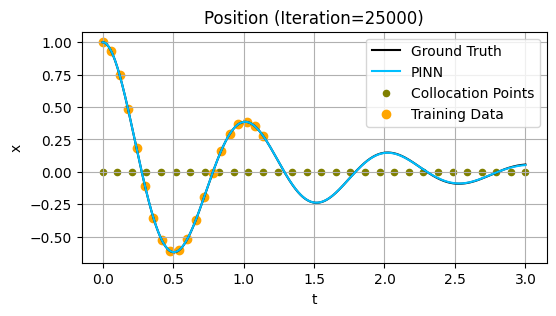

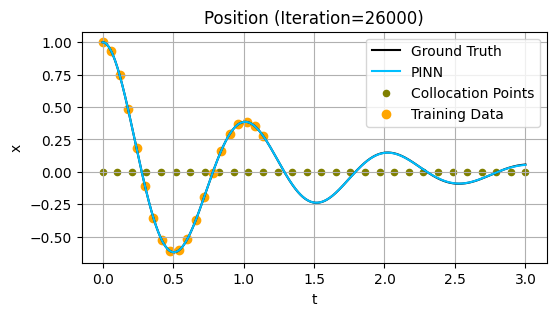

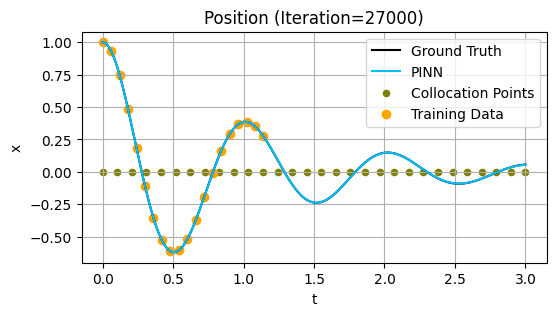

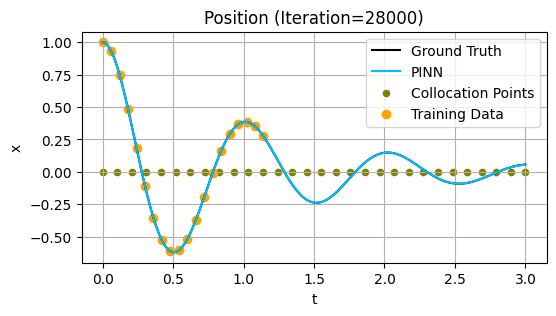

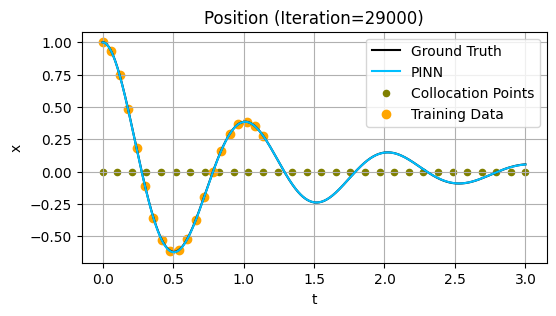

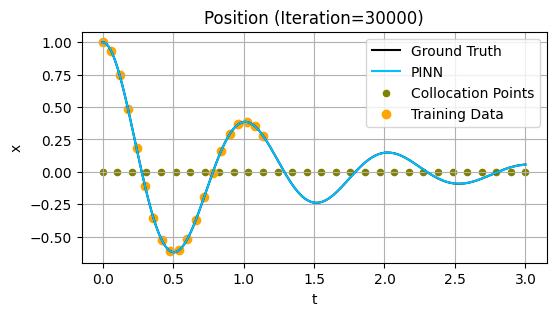

In [5]:
class Backbone(nn.Module):
    def __init__(self, dtype=torch.float32):
        super().__init__()

        self.fc1 = nn.Linear(1, 32, dtype=dtype)  # input dim = 1 (t)
        self.fc2 = nn.Linear(32, 32, dtype=dtype)  # hidden dims = 32, 32, 32
        self.fc3 = nn.Linear(32, 32, dtype=dtype)  #
        self.fc4 = nn.Linear(32, 32, dtype=dtype)  #
        self.out = nn.Linear(32, 1, dtype=dtype)  # output dim = 1 (x)

        self.dtype = dtype

    def forward(self, x):
        x = self.fc1(x)
        x = nn.SiLU()(x)
        # x = nn.Tanh()(x) 
        x = self.fc2(x)
        x = nn.SiLU()(x)
        # x = nn.Tanh()(x) 
        x = self.fc3(x)
        x = nn.SiLU()(x)
        # x = nn.Tanh()(x)
        x = self.fc4(x)
        x = nn.SiLU()(x)
        return self.out(x)
    
model = Backbone()

optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
import os
save_dir = 'results/harmonic'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
MAX_ITER = 30000
N_COLLOCATION_POINTS = 30
input = training_data[:,:1].clone().detach()    # t
output = training_data[:,1:].clone().detach()  # x
collocation_t = torch.linspace(0,Tmax,N_COLLOCATION_POINTS)
collocation_pts = torch.unsqueeze(collocation_t, -1).clone().detach().requires_grad_(True)
for iter in range(MAX_ITER):
    optimizer.zero_grad()
    prediction = model(input)
    data_loss = torch.mean((output-prediction)**2)
    
    prediction_colloc = model(collocation_pts)
    dx  = torch.autograd.grad(prediction_colloc, collocation_pts, torch.ones_like(prediction_colloc), create_graph=True)[0]
    ddx  = torch.autograd.grad(dx, collocation_pts, torch.ones_like(dx), create_graph=True)[0]
    residual = ddx + 2*zeta*omega0*dx + (omega0**2)*prediction_colloc
    physics_loss = torch.mean(residual**2)

    loss = data_loss + (1e-4)*physics_loss

    loss.backward()
    optimizer.step()

    print(f"{iter+1}/{MAX_ITER} - loss: {loss.detach().numpy():.5f}, physics: {physics_loss.detach().numpy():.5f}", end='\r')
    
    # plot the result as training progresses
    if (iter+1) % 100 == 0: 
        
        prediction = model(torch.unsqueeze(t,axis=-1)).detach()

        plt.figure(figsize=(6,3))
        plt.plot(t, GT, color='black', label = "Ground Truth")
        plt.plot(t, prediction, color='deepskyblue', label = "PINN")
        plt.scatter(collocation_t, torch.zeros_like(collocation_t), color='olive', label = "Collocation Points", s=20)
        plt.scatter(training_data[:,0], training_data[:,1], color='orange', label='Training Data')
        plt.grid()
        plt.xlabel("t")
        plt.ylabel("x")
        plt.title(f'Position (Iteration={iter+1})')
        plt.legend()
        
        file = os.path.join(save_dir, "pinn_%.6i.png"%(iter+1))
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (iter+1) % 1000 == 0: plt.show()
        else: plt.close("all")

from PIL import Image
fps = 20
imgs = [Image.open(file) for file in files]
imgs[0].save(fp="results/pinn.gif", format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=True)